Machine learning, Baseline AI downscaler

August Posch --- March-May 2025

In this notebook:
- First, using reanalysis inputs and observed precip labels, train on 1975-1994 and validate on 1995-2014.
- Try various hyperparameterizations of the above and choose the one with the best MAE-APM score on the validation set.
- Visualize the implied APM and GEV curve from the best model predictions and from the observations.

Next to-do:
- Then, using GCM inputs, do extra validation on 1995-2014 and also predict in the future period 2031-2050.


In [1]:
parameters = {
    'X_train_rean': '../data/ML_ready/boston_ERA5_1975_1994.npy',
    'y_train': '../data/ML_ready/gba_livneh_unsplit_1975_1994.npy',
    'X_val_rean': '../data/ML_ready/boston_ERA5_1995_2014.npy',
    'y_val': '../data/ML_ready/gba_livneh_unsplit_1995_2014.npy',
    'X_val_gcm': '../data/ML_ready/bos_CESM2_val.npy',
    'X_fut_gcm': '../data/ML_ready/bos_CESM2_fut.npy'
}

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import genextreme as gev
import pickle
import matplotlib.pyplot as plt

In [3]:
X_train_rean = np.load(parameters['X_train_rean'], allow_pickle=True)
y_train = np.load(parameters['y_train'], allow_pickle=True)
X_val_rean = np.load(parameters['X_val_rean'], allow_pickle=True)
y_val = np.load(parameters['y_val'], allow_pickle=True)

Define all the hyperparameterizations we will search over.

In [4]:
hyperpzns_bank = {}
increment = 0
for n_estimators in [100, 300]:
    for max_features in [12, 9, 6]:
        for min_samples_split in [2, 4]:
            for bootstrap in [False, True]:

                increment += 1
                three_digit = str(increment).zfill(3)
                hyperpzns_bank['RF'+three_digit] = {
                    'n_estimators': n_estimators,
                    'max_features': max_features,
                    'bootstrap': bootstrap,
                    'min_samples_split': min_samples_split,
                    'random_state': 19
                }

Set up a dictionary of untrained models (scikit-learn estimator objects).

In [5]:
untrained_models = {}
for name, spec in hyperpzns_bank.items():
    untrained_models[name] = RandomForestRegressor(**spec) # these are sklearn model objects (estimators)

Define a funciton `fit_predict_rean()`, which trains/fits a model based on reanalysis data, prints some validation scores, and returns the trained model and the MAE-APM score. (Note: If you hold constant the random seed, the hyperparameterization, and the training dataset, then you always end up with the same model parameters a.k.a. model specification.)

In [6]:
def fit_predict_rean(model, X_train_rean, y_train, X_val_rean, y_val):
    
    print('> Fitting the model on the training set')
    model.fit(X_train_rean, y_train)
    print('> Predicting on the validation set')
    pred = model.predict(X_val_rean)
    print('> Recording performance metrics')
    
    # Mean Absolute Error of all days 1995-2014
    error =  pred - y_val
    mae = np.mean(np.abs(error))
    print('--> Mean Absolute Error:', np.round(mae,2), 'mm')
    
    # Mean Absolute Error of Annual Precipitation Maxima 1995-2014
    pred_apm = []
    y_val_apm = []
    dpy = [365,366,365,365]*5 # days per year 1995 to 2014
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        pred_maxthisyear = max(pred[idx_yearstart:idx_nextyearstart])
        y_val_maxthisyear = max(y_val[idx_yearstart:idx_nextyearstart])
        pred_apm.append(pred_maxthisyear)
        y_val_apm.append(y_val_maxthisyear)

    pred_apm = np.array(pred_apm)
    y_val_apm = np.array(y_val_apm)
    
    error_apm =  pred_apm - y_val_apm
    mae_apm = np.mean(np.abs(error_apm))
    print('--> MAE of Annual Precip Max:', np.round(mae_apm,2), 'mm')
    
    # GEV curves and implied flood levels
    shape, loc, scale = gev.fit(y_val_apm)
    print('--> Return levels in millimeters, GEV of observations 1995-2014:')
    one_pct_level_obs, four_pct_level_obs = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_obs))
    print('----> 1/25 year level:', np.round(four_pct_level_obs))
    
    shape, loc, scale = gev.fit(pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:')
    one_pct_level_pred, four_pct_level_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_pred))
    print('----> 1/25 year level:', np.round(four_pct_level_pred))

    return model, mae_apm

Train with all the different hyperparameterizations; record trained models and their scores. (This took a couple hours on August's laptop.)

In [7]:
trained_models = {}
scores = {}
for name, untrained_model in untrained_models.items():
    # (could add a check here to only train if it hasn't been trained before)
    print('Model Name:', name)
    trained_model, score = fit_predict_rean(untrained_model, X_train_rean, y_train, X_val_rean, y_val)
    
    trained_models[name] = trained_model
    scores[name] = score

Model Name: RF001
> Fitting the model on the training set
> Predicting on the validation set
> Recording performance metrics
--> Mean Absolute Error: 3.82 mm
--> MAE of Annual Precip Max: 20.46 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 112.0
----> 1/25 year level: 103.0
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 75.0
----> 1/25 year level: 75.0
Model Name: RF002
> Fitting the model on the training set
> Predicting on the validation set
> Recording performance metrics
--> Mean Absolute Error: 3.06 mm
--> MAE of Annual Precip Max: 33.69 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 112.0
----> 1/25 year level: 103.0
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 56.0
----> 1/25 year level: 50.0
Model Name: RF003
> Fitting the model on the training set
> Predicting on the va

Identify best model and save it.

In [8]:
# "Which model name had the highest score?"
name_of_best = min(scores, key=scores.get)
print(f'The best model was {name_of_best}, achieving an MAE-APM of {scores[name_of_best]} mm')

print('This model used the following hyperparameterizations:\n', hyperpzns_bank[name_of_best])

# Save the trained model
path = '../trained_models/best_model.pkl'
pickle.dump(trained_models[name_of_best], open(path, 'wb'), protocol=5) 
print('Trained model saved here:', path)

# note about loading later - code looks like below
# model = pickle.load(open(filename, 'rb'))

The best model was RF001, achieving an MAE-APM of 20.463336002349855 mm
This model used the following hyperparameterizations:
 {'n_estimators': 100, 'max_features': 12, 'bootstrap': False, 'min_samples_split': 2, 'random_state': 19}
Trained model saved here: ../trained_models/best_model.pkl


In [9]:
def visualize_performance_rean(model, X_val_rean, y_val):
    pred = model.predict(X_val_rean)
    print('> Performance of the model with visuals.')
    
    # Mean Absolute Error of all days 1995-2014
    error =  pred - y_val
    mae = np.mean(np.abs(error))
    print('--> Mean Absolute Error:', np.round(mae,2), 'mm')
    
    # Mean Absolute Error of Annual Precipitation Maxima 1995-2014
    pred_apm = []
    y_val_apm = []
    dpy = [365,366,365,365]*5 # days per year 1995 to 2014
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        pred_maxthisyear = max(pred[idx_yearstart:idx_nextyearstart])
        y_val_maxthisyear = max(y_val[idx_yearstart:idx_nextyearstart])
        pred_apm.append(pred_maxthisyear)
        y_val_apm.append(y_val_maxthisyear)

    pred_apm = np.array(pred_apm)
    y_val_apm = np.array(y_val_apm)

    plt.bar(np.arange(1995,2015), pred_apm, width=-0.3, align='edge', color='orange', label='Predicted by model')
    plt.bar(np.arange(1995,2015), y_val_apm, width=0.3, align='edge', color='green', label='Observed')
    plt.xticks(ticks=np.arange(1995,2015), rotation=90)
    plt.ylabel('Annual Precipitation Max (mm)')
    plt.xlabel('Year')
    plt.title('Predicted and observed Annual Precipitation Max')
    plt.legend()
    plt.savefig('../figures/APM_pred_obs.png')
    plt.show()

    error_apm =  pred_apm - y_val_apm
    mae_apm = np.mean(np.abs(error_apm))
    print('--> MAE of Annual Precip Max:', np.round(mae_apm,2), 'mm')
    
    # GEV curves and implied flood levels
    
    shape, loc, scale = gev.fit(y_val_apm)
    print('--> Return levels in millimeters, GEV of observations 1995-2014:')
    one_pct_level_obs, four_pct_level_obs = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_obs))
    print('----> 1/25 year level:', np.round(four_pct_level_obs))
    # Plot that curve
    pp = np.linspace(1/100, 0.85, 500) 
    xx = 1/pp
    yy = gev.isf(pp, shape, loc, scale)
    plt.plot(xx, yy, color='green', label='GEV of Observations')
    
    shape, loc, scale = gev.fit(pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:')
    one_pct_level_pred, four_pct_level_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', np.round(one_pct_level_pred))
    print('----> 1/25 year level:', np.round(four_pct_level_pred))
    # Plot that curve
    pp = np.linspace(1/100, 0.85, 500) 
    xx = 1/pp
    yy = gev.isf(pp, shape, loc, scale)
    plt.plot(xx, yy, color='orange', label='GEV of ML Prediction')
    plt.ylabel('Extreme precipitation level (mm)')
    plt.xlabel('Return period (years)')
    plt.title(f'GEV intensity-frequency curves from predicted and observed')
    plt.legend()
    plt.savefig('../figures/GEV_pred_obs.png')
    plt.show()

> Performance of the model with visuals.
--> Mean Absolute Error: 3.82 mm


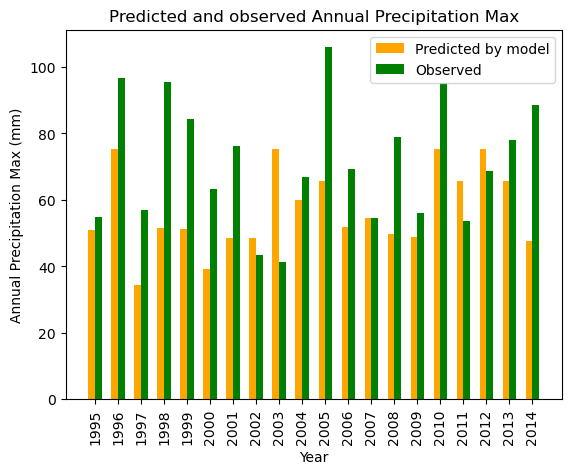

--> MAE of Annual Precip Max: 20.46 mm
--> Return levels in millimeters, GEV of observations 1995-2014:
----> 1/100 year level: 112.0
----> 1/25 year level: 103.0
--> Return levels in millimeters, GEV of ML prediction from reanalysis 1995-2014:
----> 1/100 year level: 75.0
----> 1/25 year level: 75.0


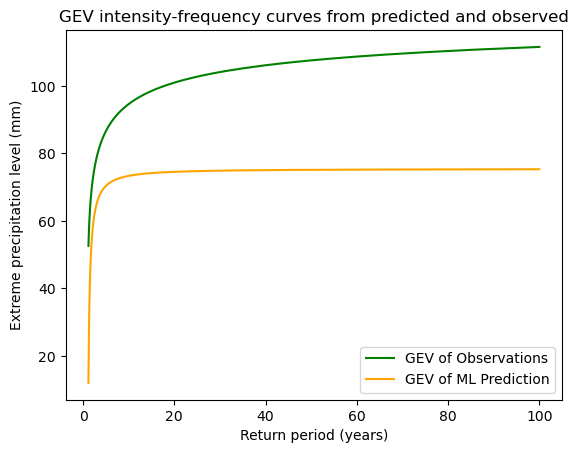

In [10]:
visualize_performance_rean(trained_models[name_of_best], X_val_rean, y_val)

Under development: predictions from climate model data.

In [11]:
def predict_gcm(model, X_val_gcm, X_fut_gcm):

    # GCM VAL SET
    print('> Predicting on the GCM validation set')
    gcm_val_pred = model.predict(X_val_gcm)
    print('> Recording performance metrics')

    # Calculate Annual Precipitation Maxima 1995-2014
    gcm_val_pred_apm = []
    dpy = [365,366,365,365]*5 # days per year 1995 to 2014
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        gcm_val_pred_maxthisyear = max(gcm_val_pred[idx_yearstart:idx_nextyearstart])
        gcm_val_pred_apm.append(gcm_val_pred_maxthisyear)

    # GEV curves and implied flood levels
    shape, loc, scale = gev.fit(gcm_val_pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from GCM historical run 1995-2014:')
    one_pct_level_gcm_val_pred, four_pct_level_gcm_val_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', one_pct_level_gcm_val_pred)
    print('----> 1/25 year level:', four_pct_level_gcm_val_pred)



    # GCM FUTURE SET
    print('> Predicting on the GCM future set')
    gcm_fut_pred = model.predict(X_fut_gcm)
    print('> Recording performance metrics')

    # Calculate Annual Precipitation Maxima 2031-2050
    gcm_fut_pred_apm = []
    dpy = [365,366,365,365]*5 # days per year 2031 to 2050
    for year in range(20):
        idx_yearstart = sum(dpy[:year])
        idx_nextyearstart = sum(dpy[:year+1])
        gcm_fut_pred_maxthisyear = max(gcm_fut_pred[idx_yearstart:idx_nextyearstart])
        gcm_fut_pred_apm.append(gcm_fut_pred_maxthisyear)

    # GEV curves and implied flood levels
    shape, loc, scale = gev.fit(gcm_fut_pred_apm)
    print('--> Return levels in millimeters, GEV of ML prediction from GCM projection 2031-2050:')
    one_pct_level_gcm_fut_pred, four_pct_level_gcm_fut_pred = gev.isf(1/100,shape,loc,scale), gev.isf(1/25,shape,loc,scale)
    print('----> 1/100 year level:', one_pct_level_gcm_fut_pred)
    print('----> 1/25 year level:', four_pct_level_gcm_fut_pred)

    return one_pct_level_gcm_fut_pred, four_pct_level_gcm_fut_pred